In [3]:
#show path
import sys
sys.path.append('../')
sys.path.append('../..')

In [4]:
import pandas as pd
from src import ComputationalHypergraphDiscovery as CHD
import matplotlib.pyplot as plt
import networkx as nx
import pickle
import glob

In [5]:

df=pd.read_csv('./data_and_results/BCR_uniform.csv')
cut=2400
df_train=df[:cut]
df_test=df[cut:]
df

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,$/partial_t S1112$,$/partial_t S1113$,$/partial_t S1114$,$/partial_t S1115$,$/partial_t S1116$,$/partial_t S1117$,$/partial_t S1118$,$/partial_t S1119$,$/partial_t S1120$,$/partial_t S1121$
0,0.872995,0.258391,0.222548,0.865075,0.006389,0.307317,0.689190,0.612599,0.032746,0.004956,...,414.121025,-607.379209,245.860647,1236.455751,3885.052506,1432.921968,2435.456029,1837.290757,664.621838,381.660465
1,0.177448,0.448519,0.892770,0.192859,0.771864,0.928737,0.017848,0.289916,0.000958,0.010268,...,355.803877,-858.675959,-2.037466,862.236998,2967.906927,2170.672995,2175.999670,2588.511472,1692.116035,1287.014376
2,0.340680,0.570078,0.998653,0.057214,0.491247,0.267313,0.412853,0.227748,0.658479,0.979586,...,212.052065,-430.789093,1091.800894,154.178383,3163.325683,1090.303392,1026.580469,1928.537903,2622.456177,550.399502
3,0.479903,0.526346,0.105414,0.382804,0.303066,0.459272,0.186838,0.460450,0.082807,0.546456,...,200.863198,-1554.053313,-890.349184,1708.265119,2454.615943,879.167918,2348.641473,1899.636315,2353.714969,1602.994661
4,0.779705,0.506842,0.873881,0.579235,0.133748,0.064157,0.164629,0.422048,0.720382,0.984089,...,-22.323701,-1081.489019,-1452.138727,1409.851417,2868.674541,1911.408665,3239.058777,2566.731976,981.383939,2672.800697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8074,0.490547,0.098756,0.725769,0.893031,0.447360,0.717609,0.020169,0.074902,0.953573,0.426310,...,335.799269,132.452240,766.229419,835.526576,3235.326364,977.768071,1691.031765,2701.452486,750.763814,1461.941421
8075,0.610184,0.137864,0.221054,0.855854,0.899311,0.321135,0.161665,0.194424,0.571655,0.896787,...,1027.543395,-862.234333,863.463471,425.377088,2529.763337,958.090513,1720.269643,1586.765812,1511.587790,1239.888173
8076,0.331995,0.811946,0.415196,0.620222,0.770606,0.588755,0.331253,0.082601,0.057621,0.889073,...,704.117458,-1345.797733,108.509009,831.918486,3221.337557,1578.396358,2635.290321,1943.616076,1736.723370,127.972618
8077,0.710465,0.211689,0.191542,0.836700,0.127878,0.946981,0.616086,0.649024,0.894440,0.505559,...,-145.045487,-780.127070,-790.319007,723.841699,1944.895869,1893.840935,1469.942838,2463.158744,252.727918,1659.376617


In [7]:
possible_edges=nx.DiGraph()
edges=[]
for f_node in df.columns:
    if 'partial' in f_node:
        continue
    for nf_node in df.columns:
        if 'partial' in nf_node:
            edges.append((f_node,nf_node))
            edges.append((nf_node,f_node))
possible_edges.add_edges_from(edges)

graph_discovery=CHD.GraphDiscovery.from_dataframe(df_train,normalize=True,possible_edges=possible_edges,kernels=[CHD.Modes.QuadraticMode(memory_efficient_required=True)],gamma_min=1e-9)

graphs = [pickle.load(open(path, "rb")) for path in glob.glob('./data_and_results/results_all_uniform_BCR/*.pkl')]
for g in graphs:
    graph_discovery.G=nx.compose(graph_discovery.G,g)

100%|██████████| 2244/2244 [00:00<00:00, 7240.65it/s]


In [12]:
true_graph=pickle.load(open('./data_and_results/BCR.pkl','rb'))

In [13]:
#compute the true positives and false negatives. For each edge in graph_discovery.G, if it is in true_graph, it is a true positive, otherwise it is a false positive
#true_graph is a networkx graph, graph_discovery.G is a networkx graph
true_positives={}
false_positives={}
false_negatives={}
true_negatives={}
random_true_positives={}
random_false_positives={}
random_false_negatives={}
random_true_negatives={}
for node in graph_discovery.G.nodes:
    if 'partial' not in node:
        continue
    true_positives[node]=0
    false_positives[node]=0
    false_negatives[node]=0
    true_negatives[node]=0
    true_ancestor_number=len(nx.ancestors(true_graph,node))
    ancestor_number=len(nx.ancestors(graph_discovery.G,node))
    random_true_positives[node]=true_ancestor_number*ancestor_number/1122
    random_false_positives[node]=(1122-true_ancestor_number)*ancestor_number/1122
    random_false_negatives[node]=true_ancestor_number*(1122-ancestor_number)/1122
    random_true_negatives[node]=(1122-true_ancestor_number)*(1122-ancestor_number)/1122

    for ancestor in graph_discovery.G.nodes:
        if 'partial' in ancestor:
            continue
        predicted=graph_discovery.G.has_edge(ancestor,node)
        true=true_graph.has_edge(ancestor,node)
        
        if predicted and true:
            true_positives[node]+=1
        elif predicted and not true:
            false_positives[node]+=1
        elif not predicted and true:
            false_negatives[node]+=1
        else:
            true_negatives[node]+=1


true_positive_rates={node:true_positives[node]/(true_positives[node]+false_negatives[node]) for node in true_positives}
false_positive_rates={node:false_positives[node]/(false_positives[node]+true_negatives[node]) for node in false_positives}
false_discovery_rates={node:false_positives[node]/(false_positives[node]+true_positives[node]) for node in false_positives}
true_negative_rates={node:true_negatives[node]/(true_negatives[node]+false_positives[node]) for node in true_negatives}
random_true_positive_rates={node:random_true_positives[node]/(random_true_positives[node]+random_false_negatives[node]) for node in random_true_positives}
random_false_positive_rates={node:random_false_positives[node]/(random_false_positives[node]+random_true_negatives[node]) for node in random_false_positives}
random_false_discovery_rates={node:random_false_positives[node]/(random_false_positives[node]+random_true_positives[node]) for node in random_false_positives}
random_true_negative_rates={node:random_true_negatives[node]/(random_true_negatives[node]+random_false_positives[node]) for node in random_true_negatives}


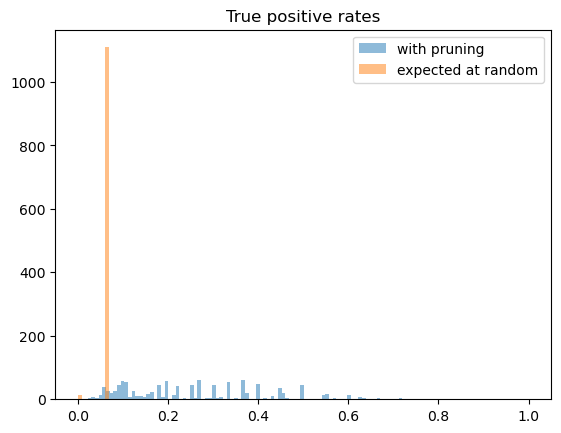

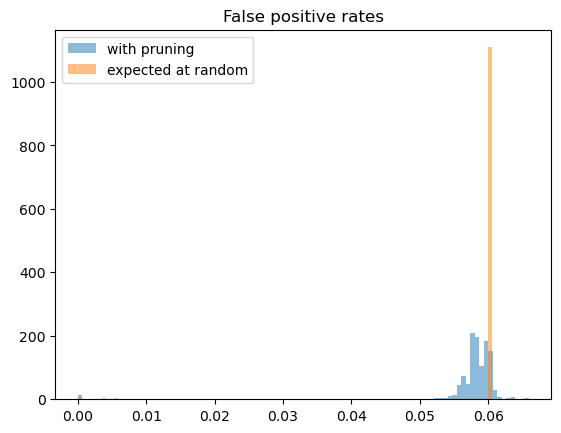

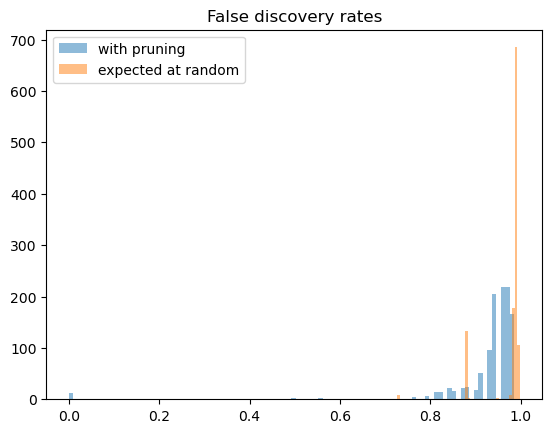

In [14]:
plt.figure()
data=list(true_positive_rates.values())
data_random=list(random_true_positive_rates.values())
plt.hist(data,bins=100,density=False,alpha=0.5,label='with pruning')
plt.hist(data_random,bins=100,density=False,alpha=0.5,label='expected at random',range=(0,1))
plt.title('True positive rates')
plt.legend()
plt.figure()
plt.hist(list(false_positive_rates.values()),bins=100,density=False,alpha=0.5,label='with pruning')
plt.hist(list(random_false_positive_rates.values()),bins=100,density=False,alpha=0.5,label='expected at random')
plt.title('False positive rates')
plt.legend()
plt.figure()
plt.hist(list(false_discovery_rates.values()),bins=100,density=False,alpha=0.5,label='with pruning')
plt.hist(list(random_false_discovery_rates.values()),bins=100,density=False,alpha=0.5,label='expected at random')
plt.title('False discovery rates')
plt.legend()
plt.show()